In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3 sentencepiece

In [3]:
!ls gdrive/MyDrive/data_image

california_wildfires  hurricane_irma   iraq_iran_earthquake  srilanka_floods
hurricane_harvey      hurricane_maria  mexico_earthquake


In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from torchvision import transforms
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "not_humanitarian":
    return 0
  elif text == "infrastructure_and_utility_damage":
    return 1
  elif text == "other_relevant_information":
    return 2
  elif text == "rescue_volunteering_or_donation_effort":
    return 3
  elif text == "affected_individuals":
    return 4

df_train = pd.read_csv("./gdrive/MyDrive/Models/train_hum.tsv", sep='\t')
df_train = df_train[['image', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/Models/val_hum.tsv", sep='\t')
df_val = df_val[['image', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/Models/test_hum.tsv", sep='\t')
df_test = df_test[['image', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [7]:
data_dir = "./gdrive/MyDrive/"
class DisasterTweetDataset(Dataset):

  def __init__(self, paths, targets):
    self.paths = paths
    self.targets = targets
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.paths)
  
  def __getitem__(self, item):
    path = str(self.paths[item])
    target = self.targets[item]

    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    return {
      'tweet_image': img,
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, batch_size):
  ds = DisasterTweetDataset(
    paths=df.image.to_numpy(),
    targets=df.label_text.to_numpy(),
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.densenet = torchvision.models.densenet161(pretrained=True)
    # for param in self.resnet.parameters():
    #   param.requires_grad = False

    self.bn = nn.BatchNorm1d(1000)
    self.linear1 = nn.Linear(1000, 256)
    self.relu    = nn.ReLU()
    self.dropout = nn.Dropout(p=0.4)
    self.linear2 = nn.Linear(256, 5)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, tweet_img):
    output = self.densenet(tweet_img)
    bn_output = self.bn(output)
    linear1_output = self.linear1(bn_output)
    relu_output = self.relu(linear1_output)
    dropout_output = self.dropout(relu_output)
    linear2_output = self.linear2(dropout_output)
    probas = self.softmax(linear2_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    targets = d["targets"].long()
    targets = targets.to(device)

    outputs = model(
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.max(outputs, dim=1).indices == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].long()
      targets = targets.to(device)

      outputs = model(
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.max(outputs, dim=1).indices == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [8]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 50

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


Epoch 1/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.0240911953151226 accuracy 0.6642180868429644
Val   loss 0.761169626377523 accuracy 0.751503006012024

Epoch 2/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5347684690107902 accuracy 0.8299053215801502
Val   loss 0.6819627396762371 accuracy 0.7755511022044087

Epoch 3/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.28044792970952886 accuracy 0.9125040809663728
Val   loss 0.7527611320838332 accuracy 0.7765531062124248

Epoch 4/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12557377727353014 accuracy 0.9647404505386875
Val   loss 0.8799826148897409 accuracy 0.7725450901803607

Epoch 5/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.06340775347416638 accuracy 0.9843290891283055
Val   loss 0.989763667806983 accuracy 0.7625250501002003

Epoch 6/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.028643612475813523 accuracy 0.9937969311132876
Val   loss 1.0653068413957953 accuracy 0.7595190380761523

Epoch 7/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.013207099514602305 accuracy 0.9970617042115573
Val   loss 1.0940589727833867 accuracy 0.7725450901803607

Epoch 8/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.005958382645985694 accuracy 0.9986940907606922
Val   loss 1.158824567683041 accuracy 0.7775551102204408

Epoch 9/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0031908284584763655 accuracy 0.9991838067254326
Val   loss 1.2633356973528862 accuracy 0.7705410821643286

Epoch 10/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0019246281503531766 accuracy 0.9998367613450865
Val   loss 1.3993392353877425 accuracy 0.7675350701402806

Epoch 11/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.002555340652368917 accuracy 0.999673522690173
Val   loss 1.2978723933920264 accuracy 0.7755511022044087

Epoch 12/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0008014482732316234 accuracy 1.0
Val   loss 1.37250008713454 accuracy 0.7805611222444889

Epoch 13/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0006479432619433586 accuracy 1.0
Val   loss 1.397733485326171 accuracy 0.7875751503006011

Epoch 14/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0013528766833132977 accuracy 0.9998367613450865
Val   loss 1.4046453582122922 accuracy 0.782565130260521

Epoch 15/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0005067771498753851 accuracy 1.0
Val   loss 1.4201752273365855 accuracy 0.782565130260521

Epoch 16/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0003266648165739146 accuracy 1.0
Val   loss 1.4360601222142577 accuracy 0.7875751503006011

Epoch 17/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0003534937022019828 accuracy 1.0
Val   loss 1.5027145445346832 accuracy 0.7845691382765531

Epoch 18/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0012136652268187238 accuracy 0.9998367613450865
Val   loss 1.4826001077890396 accuracy 0.7815631262525049

Epoch 19/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0012182339387247036 accuracy 0.9998367613450865
Val   loss 1.4922570660710335 accuracy 0.7845691382765531

Epoch 20/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0029035663043922946 accuracy 0.999347045380346
Val   loss 1.5315450970083475 accuracy 0.7695390781563125

Epoch 21/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0006882871324099445 accuracy 0.9998367613450865
Val   loss 1.5922201201319695 accuracy 0.7685370741482965

Epoch 22/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.00532981885000557 accuracy 0.9983676134508651
Val   loss 1.683178273960948 accuracy 0.7785571142284569

Epoch 23/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0027842378287440774 accuracy 0.9985308521057786
Val   loss 1.599228410050273 accuracy 0.7745490981963927

Epoch 24/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0023474496176163484 accuracy 0.9995102840352595
Val   loss 1.701269831508398 accuracy 0.7695390781563125

Epoch 25/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0006437280344139632 accuracy 0.999673522690173
Val   loss 1.7317383736371994 accuracy 0.7745490981963927

Epoch 26/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.001040259953261587 accuracy 0.9998367613450865
Val   loss 1.7404184695333242 accuracy 0.7705410821643286

Epoch 27/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0007400830942809004 accuracy 0.9998367613450865
Val   loss 1.7522573871538043 accuracy 0.7735470941883766

Epoch 28/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.00017688159587455252 accuracy 1.0
Val   loss 1.7668568044900894 accuracy 0.7675350701402806

Epoch 29/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 9.210636134090085e-05 accuracy 1.0
Val   loss 1.7718808129429817 accuracy 0.7695390781563125

Epoch 30/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0006710681682378095 accuracy 0.9998367613450865
Val   loss 1.8003798201680183 accuracy 0.7635270541082164

Epoch 31/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 9.645594727677083e-05 accuracy 1.0
Val   loss 1.804888192564249 accuracy 0.7665330661322645

Epoch 32/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 6.480769740827934e-05 accuracy 1.0
Val   loss 1.7950432756915689 accuracy 0.7655310621242485

Epoch 33/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 4.767867733571999e-05 accuracy 1.0
Val   loss 1.8082892512902617 accuracy 0.7645290581162324

Epoch 34/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 3.925449980772081e-05 accuracy 1.0
Val   loss 1.8230013949796557 accuracy 0.7645290581162324

Epoch 35/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 3.3048853136818934e-05 accuracy 1.0
Val   loss 1.8282103762030602 accuracy 0.7645290581162324

Epoch 36/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 3.278984659615958e-05 accuracy 1.0
Val   loss 1.8372007394209504 accuracy 0.7655310621242485

Epoch 37/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.8703810606600655e-05 accuracy 1.0
Val   loss 1.848627625964582 accuracy 0.7685370741482965

Epoch 38/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.8272212511855816e-05 accuracy 1.0
Val   loss 1.8536718981340528 accuracy 0.7695390781563125

Epoch 39/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.8454163163142237e-05 accuracy 1.0
Val   loss 1.8586093978956342 accuracy 0.7685370741482965

Epoch 40/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.305411071882683e-05 accuracy 1.0
Val   loss 1.866903162561357 accuracy 0.7695390781563125

Epoch 41/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.401179415301158e-05 accuracy 1.0
Val   loss 1.8745385594666004 accuracy 0.7715430861723446

Epoch 42/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.2418596248741096e-05 accuracy 1.0
Val   loss 1.8829266466200352 accuracy 0.7705410821643286

Epoch 43/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.049380117992901e-05 accuracy 1.0
Val   loss 1.8869111761450768 accuracy 0.7725450901803607

Epoch 44/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.080846321206309e-05 accuracy 1.0
Val   loss 1.8929759478196502 accuracy 0.7715430861723446

Epoch 45/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.8206978469474205e-05 accuracy 1.0
Val   loss 1.8993515660986304 accuracy 0.7725450901803607

Epoch 46/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.0663503506786658e-05 accuracy 1.0
Val   loss 1.9069372890517116 accuracy 0.7735470941883766

Epoch 47/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.9030452654315393e-05 accuracy 1.0
Val   loss 1.9134348686784506 accuracy 0.7735470941883766

Epoch 48/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.850902566324919e-05 accuracy 1.0
Val   loss 1.9143757419660687 accuracy 0.7735470941883766

Epoch 49/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.783896419560449e-05 accuracy 1.0
Val   loss 1.9165347376838326 accuracy 0.7735470941883766

Epoch 50/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.9539679620095285e-05 accuracy 1.0
Val   loss 1.917069185525179 accuracy 0.7735470941883766



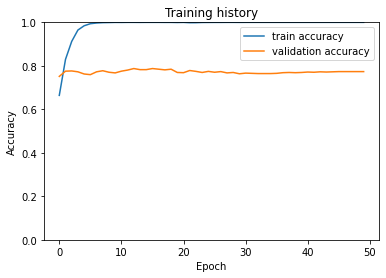

In [9]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/Models/Densenet/checkpoint.t7")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']

# print(start_epoch)


for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )
  # scheduler.step(val_acc)
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/Models/Densenet/checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc

state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/Densenet/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}


savepath= "./gdrive/MyDrive/Models/Densenet/checkpoint-{}.t7".format(start_epoch + EPOCHS)

torch.save(state,savepath)

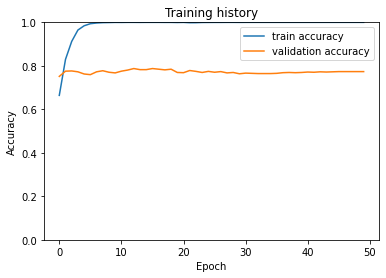

In [10]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()

plt.ylim([0, 1]);

In [11]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].long()
      targets = targets.to(device)

      outputs = model(tweet_img=tweet_imgs)
      preds = torch.max(outputs, dim=1).indices

      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['not_humanitarian', 'infrastructure_and_utility_damage', 'other_relevant_information', 'rescue_volunteering_or_donation_effort', 'affected_individuals'], digits = 4))

                                        precision    recall  f1-score   support

                      not_humanitarian     0.8305    0.8849    0.8569       504
     infrastructure_and_utility_damage     0.7727    0.8395    0.8047        81
            other_relevant_information     0.8519    0.7830    0.8160       235
rescue_volunteering_or_donation_effort     0.6697    0.5794    0.6213       126
                  affected_individuals     0.4000    0.2222    0.2857         9

                              accuracy                         0.8094       955
                             macro avg     0.7050    0.6618    0.6769       955
                          weighted avg     0.8056    0.8094    0.8059       955

